In [1]:
import pandas as pd
import sqlite3
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import numpy as np

### Extracting and Storing Stock Data

In [2]:
# Define the symbols of the stocks you want to fetch data for
symbols = ['AMZN', 'TSLA', 'AAPL']

In [3]:
# Function to get historical stock data from Yahoo Finance
def get_stock_data(symbols):
    start_date = datetime.today() - timedelta(days = 5 * 365)
    end_date = datetime.today() - timedelta(days = 365*1)
    stock_data = {}
    for symbol in symbols:
        try:
            stock_data[symbol] = yf.download(symbol, start=start_date, end=end_date)
            print(f"Successfully fetched data for {symbol}")
        except Exception as e:
            print(f"Failed to fetch data for {symbol}: {e}")
    return stock_data

In [4]:
def drop_table_if_exists(db_name, table_name):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()

    # Check if the table exists in the database
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name=?", (table_name,))
    table_exists = cursor.fetchone() is not None

    if table_exists:
        # If the table exists, drop it
        cursor.execute(f"DROP TABLE {table_name}")
        print(f"Table '{table_name}' has been dropped.")
    else:
        print(f"Table '{table_name}' does not exist.")

    connection.commit()
    connection.close()

In [5]:
db_name = 'stock_data.db'
table_name = 'stock_data'

In [6]:
# Function to create and store data in SQLite database
def store_in_database(data, db_name):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()

    drop_table_if_exists(db_name, table_name)

    # Create a table with columns for Date, Open, High, Low, Close, Volume, and Stock Symbol
    create_table_query = '''
        CREATE TABLE IF NOT EXISTS stock_data (
            Date TEXT,
            Open REAL,
            High REAL,
            Low REAL,
            Close REAL,
            Volume INTEGER,
            Symbol TEXT
        )
    '''
    cursor.execute(create_table_query)

    # Store the data in the database
    for symbol, df in data.items():
        for index, row in df.iterrows():
            values = (str(index), row['Open'], row['High'], row['Low'], row['Close'], row['Volume'], symbol)
            cursor.execute('INSERT INTO stock_data VALUES (?, ?, ?, ?, ?, ?, ?)', values)

    connection.commit()
    connection.close()


In [7]:
stock_data = get_stock_data(symbols)
store_in_database(stock_data, 'stock_data.db')
print("Data has been stored in the database.")

[*********************100%***********************]  1 of 1 completed
Successfully fetched data for AMZN
[*********************100%***********************]  1 of 1 completed
Successfully fetched data for TSLA
[*********************100%***********************]  1 of 1 completed
Successfully fetched data for AAPL
Table 'stock_data' has been dropped.
Data has been stored in the database.


In [8]:
# Function to create a DataFrame of the existing data in the database
def get_existing_data(db_name):
    connection = sqlite3.connect(db_name)
    query = "SELECT * FROM stock_data"
    df = pd.read_sql_query(query, connection)
    connection.close()

    # Convert 'Date' column to datetime type
    df['Date'] = pd.to_datetime(df['Date'])
    return df

In [9]:
# Function to create time series plot for each ticker
def plot_time_series(existing_data):
    symbols = existing_data['Symbol'].unique()

    for symbol in symbols:
        data = existing_data[existing_data['Symbol'] == symbol]
        plt.figure(figsize=(10, 6))
        plt.plot(data['Date'], data['Close'], label=symbol)
        plt.xlabel('Date')
        plt.ylabel('Closing Price')
        plt.title(f'{symbol} Stock Price Time Series')
        plt.legend()
        plt.grid(True)

        # Format x-axis dates as 'YYYY-MM-DD'
        date_format = mdates.DateFormatter('%Y-%m-%d')
        plt.gca().xaxis.set_major_formatter(date_format)
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

        # Rotate x-axis labels for better visibility
        plt.xticks(rotation=45)
        
        plt.show()

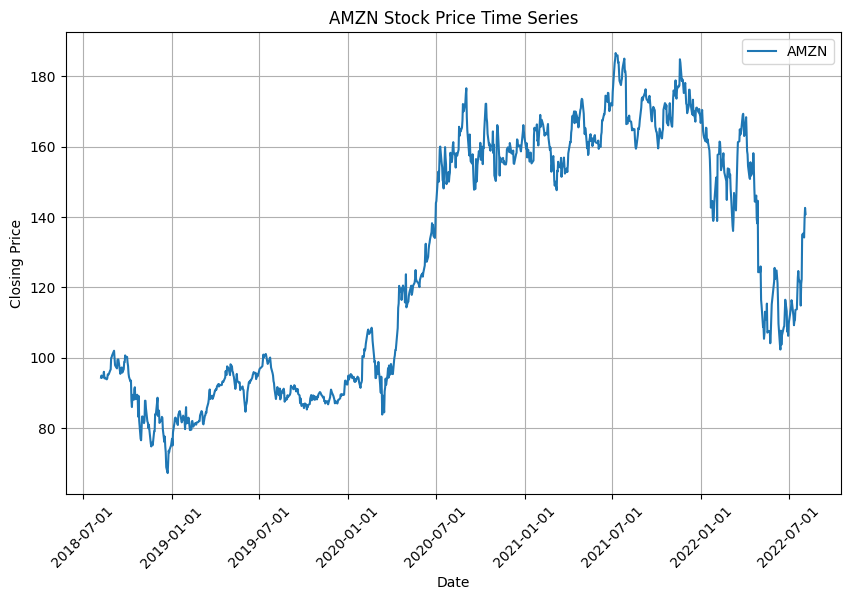

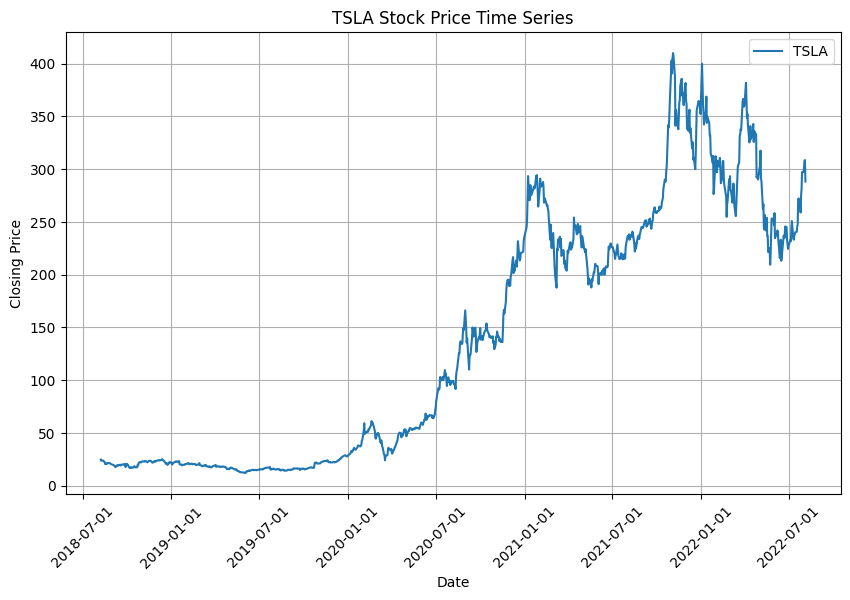

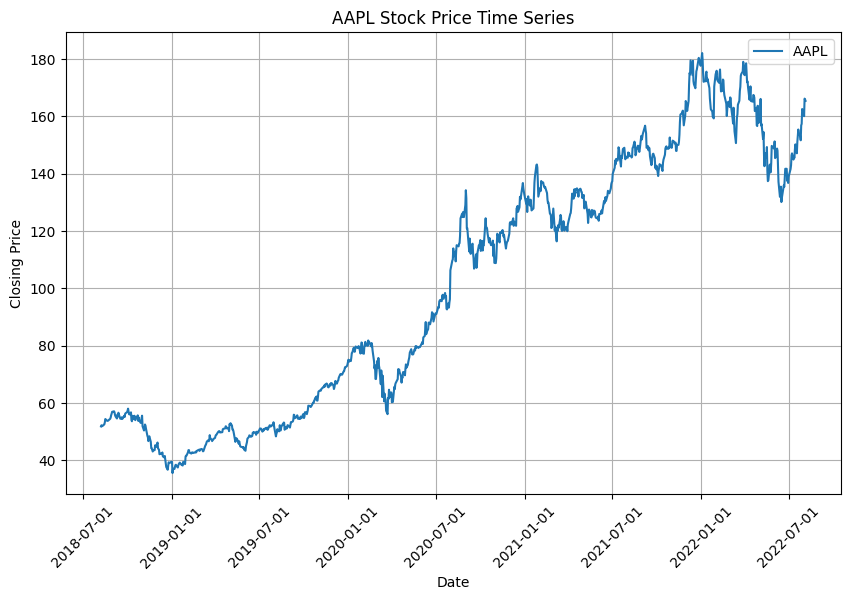

In [10]:
plot_time_series(get_existing_data('stock_data.db'))

### Appending The missing data

In [11]:
# Function to get historical stock data from Yahoo Finance for a symbol from yesterday until the last date with missing data
def get_missing_stock_data(symbol, last_date):
    yesterday = datetime.today().date() - timedelta(days=1)

    # If last_date is None, set it to 365 days ago to fetch data for the past year
    if last_date is None:
        last_date = yesterday - timedelta(days=365)

    try:
        stock_data = yf.download(symbol, start=last_date, end=yesterday)
        print(f"Successfully fetched data for {symbol} from {last_date} to {yesterday}")
        return stock_data
    except Exception as e:
        print(f"Failed to fetch data for {symbol}: {e}")
        return None

In [12]:
def fetch_missing_data(db_name, symbols):
    # Get existing data from the database
    existing_data = get_existing_data(db_name)

    # Create a dictionary to store the last available date for each ticker in the database
    last_dates = {}
    for symbol in symbols:
        if symbol in existing_data['Symbol'].unique():
            last_dates[symbol] = existing_data[existing_data['Symbol'] == symbol]['Date'].max()

    print(last_dates)

    # Fetch missing data for each ticker and update the DataFrame
    for symbol in symbols:
        start_date = last_dates.get(symbol, None)
        if start_date is not None:
            # If data is already available for this symbol, fetch data from the next day until yesterday
            start_date = start_date + timedelta(days=1)
        else:
            # If no data is available for this symbol, fetch data for the last 5 years
            start_date = datetime.today() - timedelta(days=365*5)

        end_date = datetime.today() - timedelta(days=1)

        print(end_date)
        
        try:
            missing_data = yf.download(symbol, start=start_date, end=end_date)
            missing_data.reset_index(inplace = True)
            if not missing_data.empty:
                # Append the missing data to the existing_data DataFrame
                missing_data['Symbol'] = symbol
                missing_data['Date'] = pd.to_datetime(missing_data['Date'])
                missing_data = missing_data[list(existing_data.columns)]
                existing_data = pd.concat([existing_data, missing_data], axis=0, ignore_index=True)
                print(f"Successfully fetched missing data for {symbol}")
            else:
                print(f"No missing data found for {symbol}")
        except Exception as e:
            print(f"Failed to fetch missing data for {symbol}: {e}")

    return existing_data

{'AMZN': Timestamp('2022-08-05 00:00:00'), 'TSLA': Timestamp('2022-08-05 00:00:00'), 'AAPL': Timestamp('2022-08-05 00:00:00')}
2023-08-06 01:15:30.002828
[*********************100%***********************]  1 of 1 completed
Successfully fetched missing data for AMZN
2023-08-06 01:15:30.448985
[*********************100%***********************]  1 of 1 completed
Successfully fetched missing data for TSLA
2023-08-06 01:15:30.634429
[*********************100%***********************]  1 of 1 completed
Successfully fetched missing data for AAPL


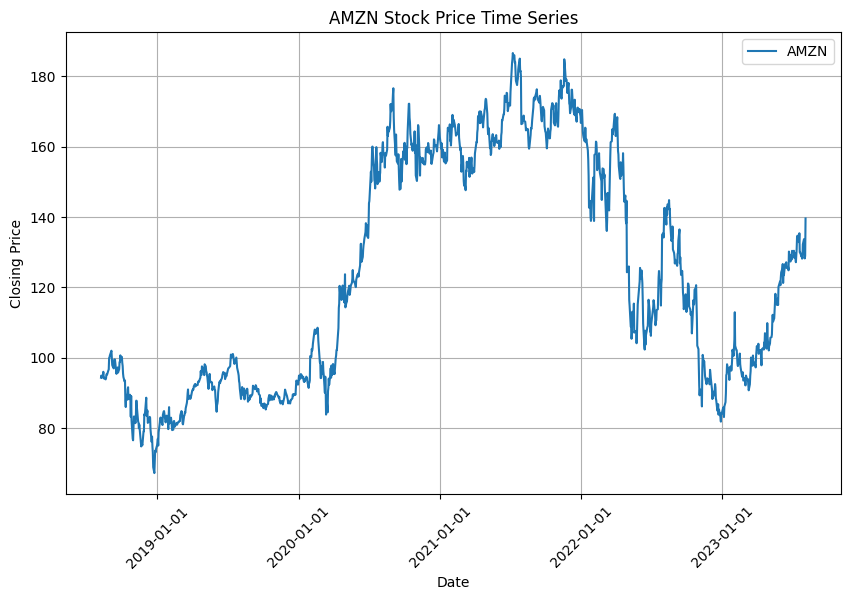

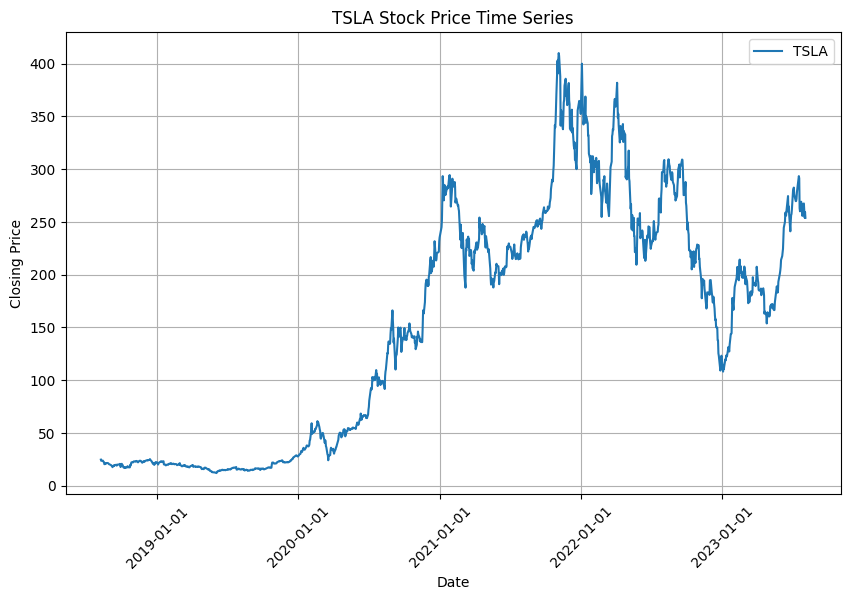

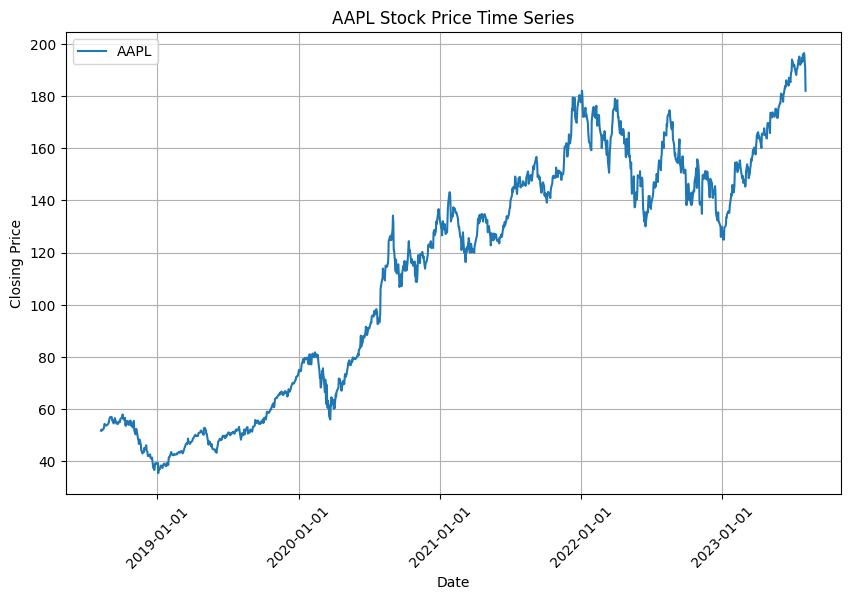

Date       Open       High        Low      Close     Volume Symbol
0 2018-08-08  93.050003  94.575500  92.724998  94.325996   79260000   AMZN
1 2018-08-09  94.099998  95.728500  93.874001  94.926003   97208000   AMZN
2 2018-08-10  94.425499  94.974998  93.910500  94.315002   72798000   AMZN
3 2018-08-13  94.925003  96.250000  94.683502  94.809998  110630000   AMZN
4 2018-08-14  95.969498  96.050499  95.000000  95.982498   79722000   AMZN

In [13]:
cd = fetch_missing_data('stock_data.db',symbols=symbols)
plot_time_series(cd)
cd.head()

In [14]:
cd.tail()

Date        Open        High         Low       Close     Volume  \
3763 2023-07-31  196.059998  196.490005  195.259995  196.449997   38824100   
3764 2023-08-01  196.240005  196.729996  195.279999  195.610001   35175100   
3765 2023-08-02  195.039993  195.179993  191.850006  192.580002   50389300   
3766 2023-08-03  191.570007  192.369995  190.690002  191.169998   61235200   
3767 2023-08-04  185.520004  187.380005  181.919998  181.990005  115799700   

     Symbol  
3763   AAPL  
3764   AAPL  
3765   AAPL  
3766   AAPL  
3767   AAPL

In [15]:
tickers = ['AMZN', 'TSLA', 'AAPL']

In [16]:
# Step 1: Split the data into training and test sets (80% training, 20% testing)
train_ratio = 0.8

In [17]:
# Split data based on the ticker
train_data = {}
test_data = {}
for ticker in tickers:
    ticker_data = cd[cd['Symbol'] == ticker]
    train_size = int(train_ratio * ticker_data.shape[0])
    train_data[ticker] = ticker_data.iloc[:train_size]
    test_data[ticker] = ticker_data.iloc[train_size:]

In [18]:
train_data['TSLA']['Close'].min()

11.9313325881958

In [19]:
min_max_scaling = {}
for ticker in tickers:
    min_max_scaling[ticker] = [train_data[ticker]['Close'].min(),train_data[ticker]['Close'].max()]
    train_data[ticker]['Close'] = (train_data[ticker]['Close'] -  min_max_scaling[ticker][0])/ (min_max_scaling[ticker][1] - min_max_scaling[ticker][0])
    test_data[ticker]['Close'] = (test_data[ticker]['Close'] -  min_max_scaling[ticker][0])/ (min_max_scaling[ticker][1] - min_max_scaling[ticker][0])

/var/folders/lx/wx3109f56_50_r0_22hgbcjr0000gn/T/ipykernel_49274/4253774333.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[ticker]['Close'] = (train_data[ticker]['Close'] -  min_max_scaling[ticker][0])/ (min_max_scaling[ticker][1] - min_max_scaling[ticker][0])
/var/folders/lx/wx3109f56_50_r0_22hgbcjr0000gn/T/ipykernel_49274/4253774333.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[ticker]['Close'] = (test_data[ticker]['Close'] -  min_max_scaling[ticker][0])/ (min_max_scaling[t

In [20]:
# Step 2: Create time series sequences
def create_time_series_sequences(data, input_seq_length=30, output_seq_length=1):
    sequences = []
    targets = []
    for i in range(len(data) - input_seq_length - output_seq_length + 1):
        seq = data['Close'].values[i:i + input_seq_length]
        target = data['Close'].values[i + input_seq_length + output_seq_length - 1]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [21]:
input_seq_length = 60  # Number of previous days' closing prices as input
output_seq_length = 10  # Number of days to predict

In [22]:
train_sequences = {}
train_targets = {}
test_sequences = {}
test_targets = {}
for ticker in tickers:
    train_sequences[ticker], train_targets[ticker] = create_time_series_sequences(train_data[ticker],
                                                                                   input_seq_length,
                                                                                   output_seq_length)
    test_sequences[ticker], test_targets[ticker] = create_time_series_sequences(test_data[ticker],
                                                                                 input_seq_length,
                                                                                 output_seq_length)

In [23]:
# Step 3: Define the deeper LSTM neural network architecture with Huber loss
def create_model(ticker):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, input_shape=(input_seq_length, 1), return_sequences=True),
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(output_seq_length)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.5*1e-4)
    model.compile(optimizer=tf.keras.optimizers.SGD(), loss='huber_loss', metrics = ['mae'])
    return model

In [24]:
# Step 4: Train the models for each ticker and save the models to files
for ticker in tickers:
    print(f"Training model for {ticker}...")
    
    # Create and train the model for the specific ticker
    model = create_model(ticker)
    model.fit(train_sequences[ticker], train_targets[ticker], epochs=50, batch_size=32)

    # Save the model to a file
    model.save(f'model_{ticker}.h5')

    # Evaluate the model on the test data for the specific ticker
    loss = model.evaluate(test_sequences[ticker], test_targets[ticker])
    print(f"{ticker} Test Loss: {loss}")
print("All models trained and saved.")

2023-08-07 01:15:31.682391: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-08-07 01:15:31.682412: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-07 01:15:31.682418: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-07 01:15:31.682448: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-07 01:15:31.682464: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Training model for AMZN...


Epoch 1/50


2023-08-07 01:15:33.630012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:15:34.012548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:15:34.071906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:15:34.130031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:15:34.185720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:15:34.336672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:15:34.442431: I tensorflow/core/grappler/optimizers/cust

 1/30 [>.............................] - ETA: 1:12 - loss: 0.1697 - mae: 0.5235

2023-08-07 01:15:34.538252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:15:34.632316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 4s 37ms/step - loss: 0.1675 - mae: 0.4994
Epoch 2/50
30/30 [==============================] - 1s 30ms/step - loss: 0.1420 - mae: 0.4471
Epoch 3/50
30/30 [==============================] - 1s 30ms/step - loss: 0.1199 - mae: 0.3990
Epoch 4/50
30/30 [==============================] - 1s 30ms/step - loss: 0.1004 - mae: 0.3579
Epoch 5/50
30/30 [==============================] - 1s 29ms/step - loss: 0.0839 - mae: 0.3273
Epoch 6/50
30/30 [==============================] - 1s 29ms/step - loss: 0.0709 - mae: 0.3058
Epoch 7/50
30/30 [==============================] - 1s 33ms/step - loss: 0.0607 - mae: 0.2902
Epoch 8/50
30/30 [==============================] - 1s 29ms/step - loss: 0.0535 - mae: 0.2792
Epoch 9/50
30/30 [==============================] - 1s 29ms/step - loss: 0.0484 - mae: 0.2717
Epoch 10/50
30/30 [==============================] - 1s 29ms/step - loss: 0.0447 - mae: 0.2665
Epoch 11/50
30/30 [==============================] - 1s 29ms/step - lo

/Users/sarat/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2023-08-07 01:16:19.497695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:16:19.636069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:16:19.675031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/6 [========================>.....] - ETA: 0s - loss: 0.0081 - mae: 0.0992

2023-08-07 01:16:19.722938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:16:19.769870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 25ms/step - loss: 0.0072 - mae: 0.0911
AMZN Test Loss: [0.007229460868984461, 0.09109389036893845]
Training model for TSLA...


Epoch 1/50


2023-08-07 01:16:21.754597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:16:22.133385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:16:22.186032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:16:22.240135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:16:22.297231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:16:22.410362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:16:22.509177: I tensorflow/core/grappler/optimizers/cust

 1/30 [>.............................] - ETA: 1:11 - loss: 0.1491 - mae: 0.4634

2023-08-07 01:16:22.613040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:16:22.706968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 4s 36ms/step - loss: 0.0942 - mae: 0.3226
Epoch 2/50
30/30 [==============================] - 1s 31ms/step - loss: 0.0842 - mae: 0.3061
Epoch 3/50
30/30 [==============================] - 1s 30ms/step - loss: 0.0764 - mae: 0.2963
Epoch 4/50
30/30 [==============================] - 1s 29ms/step - loss: 0.0702 - mae: 0.2889
Epoch 5/50
30/30 [==============================] - 1s 30ms/step - loss: 0.0651 - mae: 0.2834
Epoch 6/50
30/30 [==============================] - 1s 30ms/step - loss: 0.0608 - mae: 0.2783
Epoch 7/50
30/30 [==============================] - 1s 30ms/step - loss: 0.0571 - mae: 0.2741
Epoch 8/50
30/30 [==============================] - 1s 31ms/step - loss: 0.0540 - mae: 0.2708
Epoch 9/50
30/30 [==============================] - 1s 30ms/step - loss: 0.0513 - mae: 0.2677
Epoch 10/50
30/30 [==============================] - 1s 29ms/step - loss: 0.0491 - mae: 0.2652
Epoch 11/50
30/30 [==============================] - 1s 29ms/step - lo

2023-08-07 01:17:07.074038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:17:07.209141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:17:07.250453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/6 [========================>.....] - ETA: 0s - loss: 0.0090 - mae: 0.1120

2023-08-07 01:17:07.302544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:17:07.352752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 28ms/step - loss: 0.0088 - mae: 0.1109
TSLA Test Loss: [0.00875319354236126, 0.11094485968351364]
Training model for AAPL...


Epoch 1/50


2023-08-07 01:17:09.181493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:17:09.543099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:17:09.600716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:17:09.660948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:17:09.729875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:17:09.849619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:17:09.945679: I tensorflow/core/grappler/optimizers/cust

 2/30 [=>............................] - ETA: 1s - loss: 0.1427 - mae: 0.4350  

2023-08-07 01:17:10.162581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 4s 41ms/step - loss: 0.1252 - mae: 0.4096
Epoch 2/50
30/30 [==============================] - 1s 29ms/step - loss: 0.0909 - mae: 0.3434
Epoch 3/50
30/30 [==============================] - 1s 29ms/step - loss: 0.0729 - mae: 0.3096
Epoch 4/50
30/30 [==============================] - 1s 29ms/step - loss: 0.0615 - mae: 0.2891
Epoch 5/50
30/30 [==============================] - 1s 29ms/step - loss: 0.0534 - mae: 0.2742
Epoch 6/50
30/30 [==============================] - 1s 30ms/step - loss: 0.0478 - mae: 0.2633
Epoch 7/50
30/30 [==============================] - 1s 29ms/step - loss: 0.0437 - mae: 0.2554
Epoch 8/50
30/30 [==============================] - 1s 30ms/step - loss: 0.0407 - mae: 0.2490
Epoch 9/50
30/30 [==============================] - 1s 30ms/step - loss: 0.0383 - mae: 0.2434
Epoch 10/50
30/30 [==============================] - 1s 29ms/step - loss: 0.0362 - mae: 0.2383
Epoch 11/50
30/30 [==============================] - 1s 29ms/step - lo

2023-08-07 01:17:55.947202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:17:56.103708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:17:56.148295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/6 [====>.........................] - ETA: 5s - loss: 0.0013 - mae: 0.0410

2023-08-07 01:17:56.206086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-07 01:17:56.274013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 37ms/step - loss: 0.0111 - mae: 0.1239
AAPL Test Loss: [0.011110616847872734, 0.12392593175172806]
All models trained and saved.


In [25]:
import pickle
with open('min_max.pickle', 'wb') as handle:
    pickle.dump(min_max_scaling, handle, protocol=pickle.HIGHEST_PROTOCOL)